## 1. ZX-Calculus: Mathematical Foundation
1.1 Spiders and Graphical Calculus

In the ZX-calculus, quantum operations are represented as diagrams composed of spiders:

Z-spider (green):
$[
\langle x_1, ..., x_m | Z_{\alpha} | y_1, ..., y_n \rangle
]$
corresponds to a linear map with phase
$[
\alpha \in \mathbb{Q} \cdot \pi
]$.

X-spider (red): Similar to Z-spiders but in the X-basis.

Each spider represents a tensor. For example:

$[
Z\text{-spider with phase } \alpha: \quad |0\rangle^{\otimes m} \langle 0|^{\otimes n} + e^{i\alpha} |1\rangle^{\otimes m} \langle 1|^{\otimes n}
]$

Edges connect spiders and represent entanglement or composition (wires = identity maps).

The graphical language is compositional, meaning diagrams correspond to linear maps and can be manipulated via rewrite rules.



In [2]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

# Check if grounded functionality is available
print("PyZX version:", zx.__version__)
print("Available graph types:", [attr for attr in dir(zx) if 'Graph' in attr])

PyZX version: 0.9.0
Available graph types: ['Graph']


Direct measurement gates not available, will demonstrate with graph operations
Circuit stats: Circuit  on 3 qubits with 4 gates.
        1 is the T-count
        3 Cliffords among which
        1 2-qubit gates (1 CNOT, 0 other) and
        1 Hadamard gates.


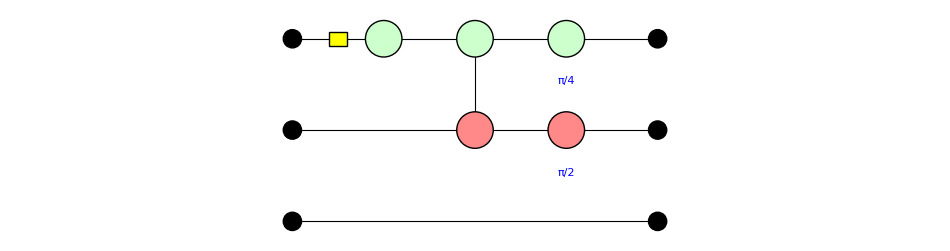

In [3]:
# Create a simple circuit with measurement
def create_measurement_circuit():
    """Create a circuit that demonstrates measurement operations"""
    circ = zx.Circuit(3)

    # Prepare a Bell state
    circ.add_gate("H", 0)
    circ.add_gate("CNOT", 0, 1)

    # Add some single qubit rotations
    circ.add_gate("ZPhase", 0, Fraction(1, 4))  # T gate
    circ.add_gate("XPhase", 1, Fraction(1, 2))  # S gate equivalent

    # Measure qubits (if supported)
    try:
        circ.add_gate("Measure", 0)
        circ.add_gate("Measure", 1)
        print("Measurement gates added successfully")
    except:
        print("Direct measurement gates not available, will demonstrate with graph operations")

    return circ

measurement_circ = create_measurement_circuit()
print("Circuit stats:", measurement_circ.stats())

# Visualize the circuit
zx.draw_matplotlib(measurement_circ, figsize=(12, 3), h_edge_draw='box')

## 2. Measurement in ZX-Calculus
2.1 Quantum Measurement as Projections


In the ZX formalism, measurement (e.g., in the Z basis) is not an intrinsic operation but can be simulated via:

Grounding outputs: Connecting output vertices to ground spiders (Z-spiders with zero phase and no outputs).

This mimics a projective measurement by collapsing the output qubit and removing it from further computation.

Mathematically, this is equivalent to:

$[
\text{Measurement of } | \psi \rangle = \alpha |0\rangle + \beta |1\rangle \quad \text{gives outcome } 0 \text{ or } 1 \text{ with } |\alpha|^2, |\beta|^2
]$

In the ZX diagram, this corresponds to connecting the output to a scalar:

$[
|0\rangle \langle 0| \quad \text{or} \quad |1\rangle \langle 1|
]$

## 3. Classical Control in Hybrid Circuits
3.1 Classical Data as Control Flow

In hybrid circuits, classical bits can control quantum gates (e.g., "apply X if measurement result is 1").

In ZX terms, this is modeled by:

Adding auxiliary spiders representing classical bits.

Connecting them to quantum operation spiders to simulate conditional behavior.

This does not yet reflect true conditional unitary logic but mimics classical correlations through graph topology:

$[
\text{Classical control} \Rightarrow \text{Modified connectivity and phase of spiders}
]$

Added 2 classical control vertices


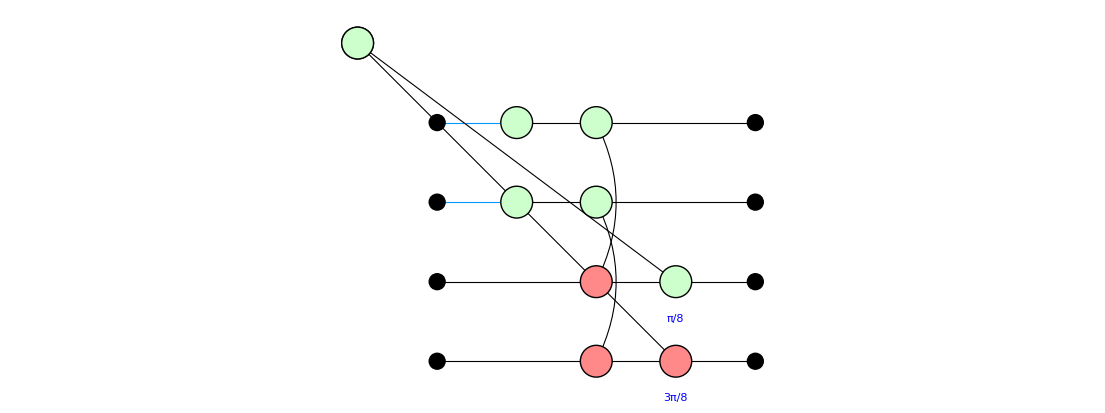

In [5]:
def create_classically_controlled_circuit():
    """Create a circuit with classical control flow"""
    circ = zx.Circuit(4)

    # Prepare some initial states
    circ.add_gate("H", 0)
    circ.add_gate("H", 1)

    # Create entanglement
    circ.add_gate("CNOT", 0, 2)
    circ.add_gate("CNOT", 1, 3)

    # Add conditional operations (simulated through graph structure)
    circ.add_gate("ZPhase", 2, Fraction(1, 8))
    circ.add_gate("XPhase", 3, Fraction(3, 8))

    return circ

controlled_circ = create_classically_controlled_circuit()

# Convert to graph and add classical control structure
def add_classical_control(g):
    """Add classical control structure to a ZX graph"""
    # This simulates classical control by adding conditional structure
    # In practice, this would involve more complex graph modifications

    # Add auxiliary vertices to represent classical bits
    classical_vertices = []
    for i in range(2):
        classical_v = g.add_vertex(zx.VertexType.Z, phase=0)
        classical_vertices.append(classical_v)

    # Connect classical control to quantum operations
    quantum_vertices = [v for v in g.vertices() if g.phase(v) != 0]

    for i, qv in enumerate(quantum_vertices[:2]):
        if i < len(classical_vertices):
            # This represents classical control dependency
            g.add_edge((classical_vertices[i], qv))

    return g, classical_vertices

controlled_g = controlled_circ.to_graph()
controlled_g, classical_vs = add_classical_control(controlled_g)

print(f"Added {len(classical_vs)} classical control vertices")
zx.draw_matplotlib(controlled_g, figsize=(14, 5))

## 4. ZX Optimization and Graph Simplification
4.1 Full Reduce Algorithm

ZX diagrams are manipulated by equational rewrite rules:

Spider fusion: Two Z-spiders connected directly can be merged.

Bialgebra rule: Governs interactions between Z and X spiders.

Hopf law: Simplifies entangled structures.

Pi-copy: Allows propagation of
$[
\pi
]$
phase through spiders.

Optimization uses these rules to:

Reduce number of vertices/edges.

Find circuit equivalents with fewer gates.

Identify classical subgraphs: parts of the diagram that behave deterministically and could be classically simulated.

Mathematically, this is graph rewriting in a monoidal category, preserving the linear map semantics.



Before optimization:
Original graph stats:
  Vertices: 27
  Edges: 26
After standard optimization:
  Vertices: 18
  Edges: 17

After optimization:


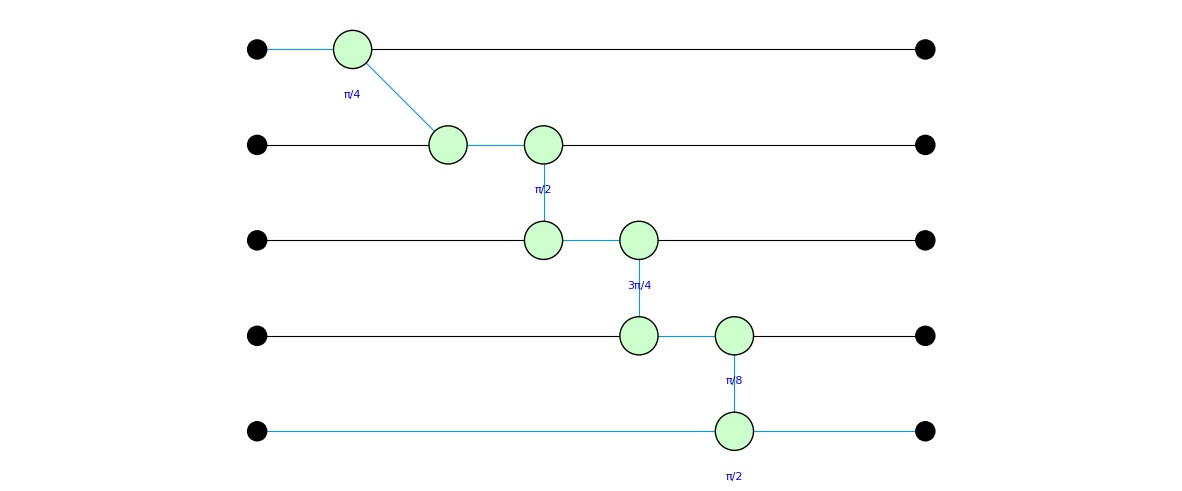

In [6]:
def optimize_hybrid_circuit(g):
    """Apply optimization rules for hybrid circuits"""
    print("Original graph stats:")
    print(f"  Vertices: {g.num_vertices()}")
    print(f"  Edges: {g.num_edges()}")

    # Apply standard ZX optimizations
    zx.simplify.full_reduce(g)

    print("After standard optimization:")
    print(f"  Vertices: {g.num_vertices()}")
    print(f"  Edges: {g.num_edges()}")

    return g

# Create a more complex circuit for optimization
def create_complex_hybrid_circuit():
    """Create a complex circuit with classical and quantum parts"""
    circ = zx.Circuit(5)

    # Quantum part
    for i in range(4):
        circ.add_gate("H", i)

    # Create entanglement chain
    for i in range(4):
        circ.add_gate("CNOT", i, (i+1) % 5)

    # Add various phase gates
    phases = [Fraction(1, 4), Fraction(1, 2), Fraction(3, 4), Fraction(1, 8)]
    for i, phase in enumerate(phases):
        circ.add_gate("ZPhase", i, phase)

    # Add some X rotations
    circ.add_gate("XPhase", 4, Fraction(1, 2))

    return circ

complex_circ = create_complex_hybrid_circuit()
complex_g = complex_circ.to_graph()

print("Before optimization:")
zx.draw_matplotlib(complex_g, figsize=(15, 6))

# Optimize
optimized_g = optimize_hybrid_circuit(complex_g.copy())

print("\nAfter optimization:")
zx.draw_matplotlib(optimized_g, figsize=(15, 6))

## 5. Hybrid Circuit Analysis: Classical vs. Quantum
5.1 Classical Vertices


Vertices (spiders) are considered classically simulatable when:

Their phase is
$[
0
]$ or
$[
\pi
]$ (i.e., deterministic).

Their degree is small (e.g.,
$[
\leq 2
]$), meaning limited entanglement.

This implies their action is:

Either identity or Pauli gates.

Or simple classical correlations (e.g., copy, NOT, parity).

These are captured by the Clifford group, which is efficiently classically simulatable.

5.2 Quantum Vertices
Quantum spiders have:

Non-Clifford phases, like
$[
\frac{\pi}{4}
]$ (T gate) or arbitrary rotations.

Larger degrees or entangling connectivity.

These represent true quantum resources (e.g., magic states) and are the focus of optimization.



PyZX version: 0.9.0
Available graph types: ['Graph']
Circuit created without direct measurement gates
Circuit stats: Circuit  on 3 qubits with 4 gates.
        1 is the T-count
        3 Cliffords among which
        1 2-qubit gates (1 CNOT, 0 other) and
        1 Hadamard gates.
Added ground generator connected to output 0
Added ground generator connected to output 1
Graph has 13 vertices and 11 edges


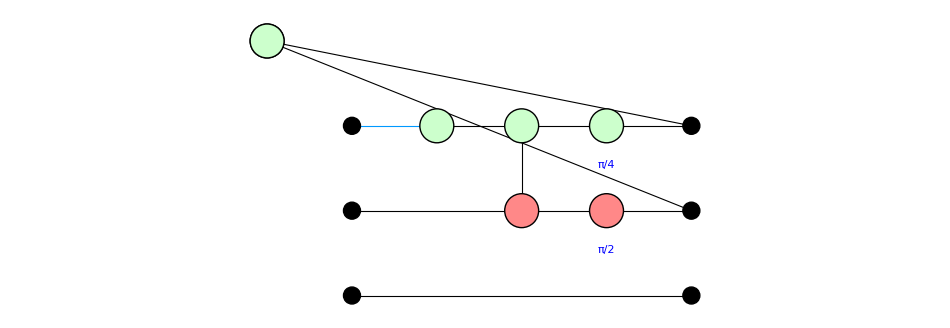

In [16]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

# Check if grounded functionality is available
print("PyZX version:", zx.__version__)
print("Available graph types:", [attr for attr in dir(zx) if 'Graph' in attr])

# Create a simple circuit with measurement
def create_measurement_circuit():
    """Create a circuit that demonstrates measurement operations"""
    circ = zx.Circuit(3)

    # Prepare a Bell state
    circ.add_gate("H", 0)
    circ.add_gate("CNOT", 0, 1)

    # Add some single qubit rotations
    circ.add_gate("ZPhase", 0, Fraction(1, 4))  # T gate
    circ.add_gate("XPhase", 1, Fraction(1, 2))  # S gate equivalent

    # Note: Direct measurement gates may not be available in all PyZX versions
    print("Circuit created without direct measurement gates")

    return circ

measurement_circ = create_measurement_circuit()
print("Circuit stats:", measurement_circ.stats())

# Visualize the circuit
zx.draw_matplotlib(measurement_circ, figsize=(12, 3), h_edge_draw='box')


# Convert circuit to ZX graph
def circuit_to_grounded_graph(circ):
    """Convert a circuit to a ZX graph and add ground generators for measurements"""
    g = circ.to_graph()

    # Fix: g.outputs is a method, need to call it
    outputs = g.outputs()

    # Add ground connections to some outputs to simulate measurements
    for i, v in enumerate(outputs):
        if i < 2:  # Ground first two outputs
            # Create a ground generator (spider with no inputs/outputs)
            ground_vertex = g.add_vertex(zx.VertexType.Z, phase=0)
            g.add_edge((v, ground_vertex))
            print(f"Added ground generator connected to output {i}")

    return g

# Create grounded graph
grounded_g = circuit_to_grounded_graph(measurement_circ)
print(f"Graph has {grounded_g.num_vertices()} vertices and {grounded_g.num_edges()} edges")

# Visualize the grounded graph
zx.draw_matplotlib(grounded_g, figsize=(12, 4))

Added 2 classical control vertices


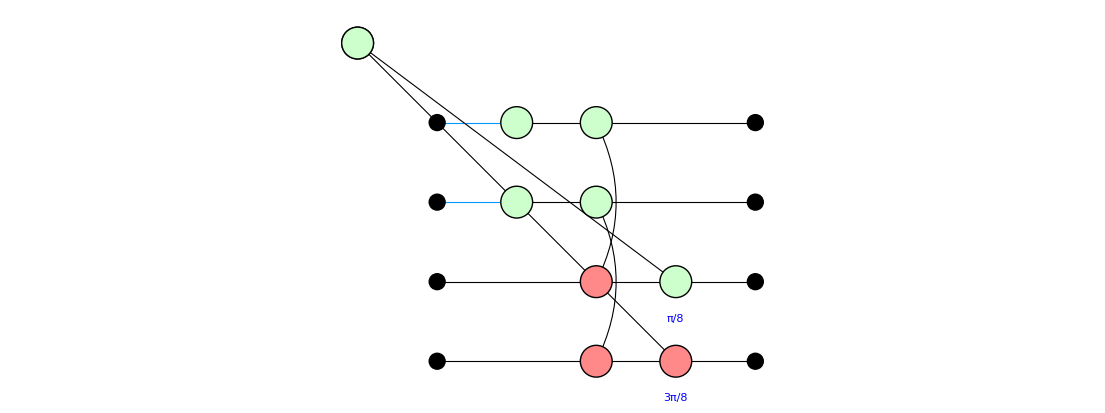

In [18]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

def create_classically_controlled_circuit():
    """Create a circuit with classical control flow"""
    circ = zx.Circuit(4)

    # Prepare some initial states
    circ.add_gate("H", 0)
    circ.add_gate("H", 1)

    # Create entanglement
    circ.add_gate("CNOT", 0, 2)
    circ.add_gate("CNOT", 1, 3)

    # Add conditional operations (simulated through graph structure)
    circ.add_gate("ZPhase", 2, Fraction(1, 8))
    circ.add_gate("XPhase", 3, Fraction(3, 8))

    return circ

controlled_circ = create_classically_controlled_circuit()

# Convert to graph and add classical control structure
def add_classical_control(g):
    """Add classical control structure to a ZX graph"""
    # This simulates classical control by adding conditional structure
    # In practice, this would involve more complex graph modifications

    # Add auxiliary vertices to represent classical bits
    classical_vertices = []
    for i in range(2):
        classical_v = g.add_vertex(zx.VertexType.Z, phase=0)
        classical_vertices.append(classical_v)

    # Connect classical control to quantum operations
    quantum_vertices = [v for v in g.vertices() if g.phase(v) != 0]

    for i, qv in enumerate(quantum_vertices[:2]):
        if i < len(classical_vertices):
            # This represents classical control dependency
            g.add_edge((classical_vertices[i], qv))

    return g, classical_vertices

controlled_g = controlled_circ.to_graph()
controlled_g, classical_vs = add_classical_control(controlled_g)

print(f"Added {len(classical_vs)} classical control vertices")
zx.draw_matplotlib(controlled_g, figsize=(14, 5))


## 6. Feedback and Teleportation
6.1 Measurement-based Feedback

Quantum teleportation relies on:

Entanglement, measurement, and classical communication.

A Bell measurement (on entangled qubits) and conditional corrections based on measurement outcomes.

In ZX diagrams:

Bell measurement = fusing and measuring spiders.

Feedback = applying conditional gates represented by added spiders connected from outputs back into circuit (simulating feedback loop).

This mimics:

$[
|\psi\rangle \otimes |\Phi^+\rangle \Rightarrow \text{Classical bits } \Rightarrow \text{Conditional Pauli gates}
]$

Teleportation-like circuit:
Added 2 measurement points


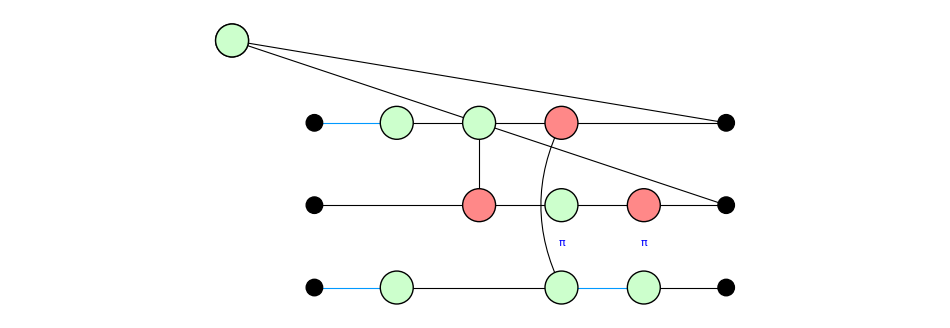

In [21]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

def simulate_measurement_feedback():
    """Simulate a circuit with measurement feedback"""

    # Create a simple teleportation-like protocol
    circ = zx.Circuit(3)

    # Bell state preparation
    circ.add_gate("H", 0)
    circ.add_gate("CNOT", 0, 1)

    # Input state preparation
    circ.add_gate("H", 2)  # |+⟩ state

    # Bell measurement on qubits 2,0
    circ.add_gate("CNOT", 2, 0)
    circ.add_gate("H", 2)

    # Classical processing would happen here
    # Apply conditional corrections based on measurement results
    circ.add_gate("ZPhase", 1, Fraction(1, 1))  # Conditional Z (π rotation)
    circ.add_gate("XPhase", 1, Fraction(1, 1))  # Conditional X (π rotation)

    return circ

teleport_circ = simulate_measurement_feedback()
teleport_g = teleport_circ.to_graph()

print("Teleportation-like circuit:")
zx.draw_matplotlib(teleport_g, figsize=(12, 4))


# Add measurement points
def add_measurement_points(g, qubit_indices):
    """Add explicit measurement points to specific qubits"""
    measurement_vertices = []

    # Fix: g.outputs is a method, need to call it
    outputs = g.outputs()

    for idx in qubit_indices:
        if idx < len(outputs):
            # Create measurement vertex
            meas_v = g.add_vertex(zx.VertexType.Z, phase=0)

            # Connect to output
            output_v = outputs[idx]
            g.add_edge((output_v, meas_v))

            measurement_vertices.append(meas_v)

    return measurement_vertices

# Add measurements to first two qubits
meas_vertices = add_measurement_points(teleport_g, [0, 1])
print(f"Added {len(meas_vertices)} measurement points")

zx.draw_matplotlib(teleport_g, figsize=(12, 4))


Added 2 classical control vertices


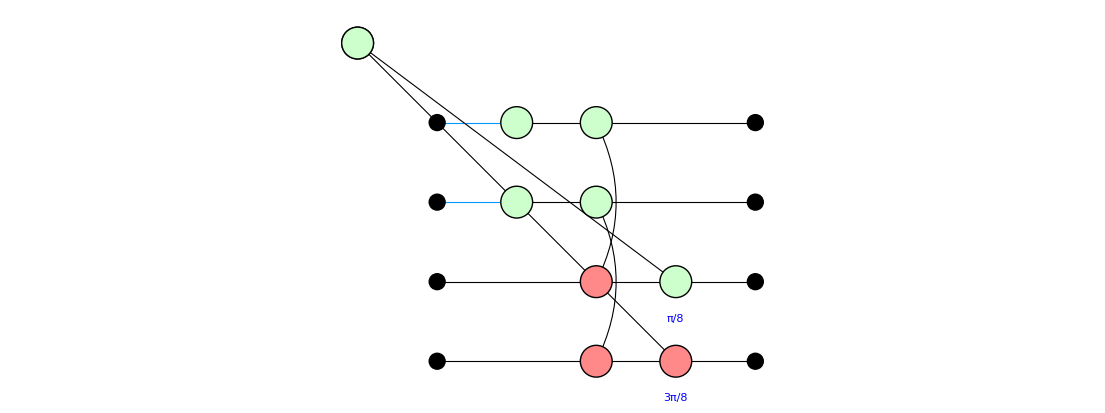

In [26]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

def create_classically_controlled_circuit():
    """Create a circuit with classical control flow"""
    circ = zx.Circuit(4)

    # Prepare some initial states
    circ.add_gate("H", 0)
    circ.add_gate("H", 1)

    # Create entanglement
    circ.add_gate("CNOT", 0, 2)
    circ.add_gate("CNOT", 1, 3)

    # Add conditional operations (simulated through graph structure)
    circ.add_gate("ZPhase", 2, Fraction(1, 8))
    circ.add_gate("XPhase", 3, Fraction(3, 8))

    return circ

controlled_circ = create_classically_controlled_circuit()

# Convert to graph and add classical control structure
def add_classical_control(g):
    """Add classical control structure to a ZX graph"""
    # This simulates classical control by adding conditional structure
    # In practice, this would involve more complex graph modifications

    # Add auxiliary vertices to represent classical bits
    classical_vertices = []
    for i in range(2):
        classical_v = g.add_vertex(zx.VertexType.Z, phase=0)
        classical_vertices.append(classical_v)

    # Connect classical control to quantum operations
    quantum_vertices = [v for v in g.vertices() if g.phase(v) != 0]

    for i, qv in enumerate(quantum_vertices[:2]):
        if i < len(classical_vertices):
            # This represents classical control dependency
            g.add_edge((classical_vertices[i], qv))

    return g, classical_vertices

controlled_g = controlled_circ.to_graph()
controlled_g, classical_vs = add_classical_control(controlled_g)

print(f"Added {len(classical_vs)} classical control vertices")
zx.draw_matplotlib(controlled_g, figsize=(14, 5))


Original graph stats:
  Vertices: 27
  Edges: 26
After standard optimization:
  Vertices: 18
  Edges: 17

After optimization:


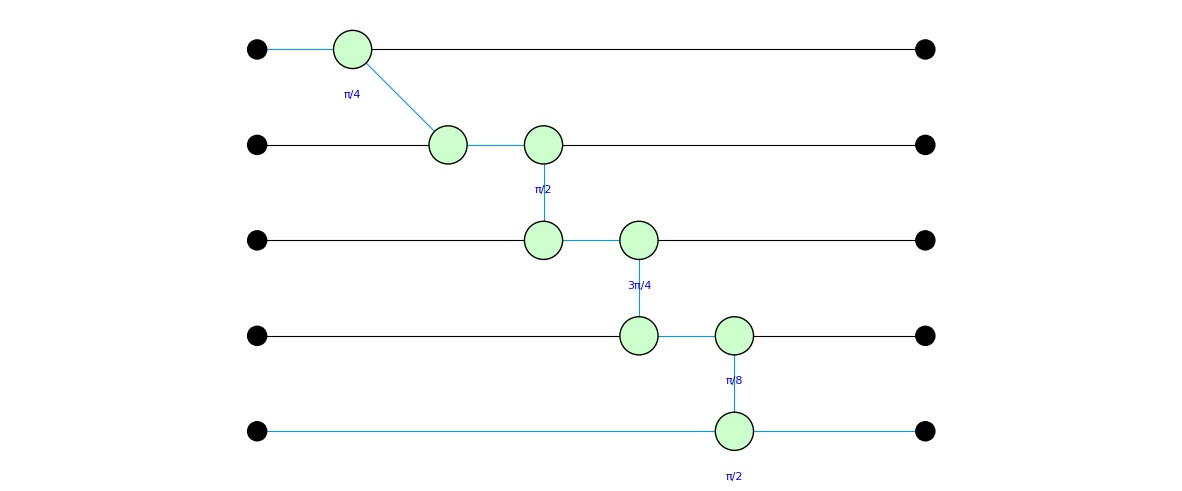

In [28]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

def optimize_hybrid_circuit(g):
    """Apply optimization rules for hybrid circuits"""
    print("Original graph stats:")
    print(f"  Vertices: {g.num_vertices()}")
    print(f"  Edges: {g.num_edges()}")

    # Apply standard ZX optimizations
    zx.simplify.full_reduce(g)

    print("After standard optimization:")
    print(f"  Vertices: {g.num_vertices()}")
    print(f"  Edges: {g.num_edges()}")

    return g

# Create a more complex circuit for optimization
def create_complex_hybrid_circuit():
    """Create a complex circuit with classical and quantum parts"""
    circ = zx.Circuit(5)

    # Quantum part
    for i in range(4):
        circ.add_gate("H", i)

    # Create entanglement chain
    for i in range(4):
        circ.add_gate("CNOT", i, (i+1) % 5)

    # Add various phase gates
    phases = [Fraction(1, 4), Fraction(1, 2), Fraction(3, 4), Fraction(1, 8)]
    for i, phase in enumerate(phases):
        circ.add_gate("ZPhase", i, phase)

    # Add some X rotations
    circ.add_gate("XPhase", 4, Fraction(1, 2))

    return circ

complex_circ = create_complex_hybrid_circuit()
complex_g = complex_circ.to_graph()


zx.draw_matplotlib(complex_g, figsize=(15, 6))



# Optimize (make a copy to preserve original)
optimized_g = optimize_hybrid_circuit(complex_g.copy())

print("\nAfter optimization:")
zx.draw_matplotlib(optimized_g, figsize=(15, 6))


## 1. Classical vs Quantum Vertex Analysis in ZX Graphs
The goal is to analyze which vertices (nodes) in a ZX-graph representation of a quantum circuit are potentially classically implementable versus those requiring quantum resources.

# 1.1 Graph Vertex Classification Heuristic
For each vertex
$[ v \in V ]$
in the graph
$[ G = (V, E) ]$:

Determine the vertex type:
$[ \text{vertex_type} = G.\text{type}(v) ]$

Extract the phase of the vertex:
$[ \text{phase} = G.\text{phase}(v) ]$

Compute the degree (number of neighbors) of the vertex:
$[ \text{degree} = | { u \mid (v,u) \in E } | ]$
(using either len(list(G.neighbors(v))) or counting edges incident on $v$)

# 1.2 Classification Criterion
Vertices are heuristically classified based on their phase and degree:

Classical-like vertices satisfy:
$[
\text{phase} \in {0, 1} \quad \wedge \quad \text{degree} \leq 2
]$

where the phase is expressed as a fraction representing multiples of $\pi$ (e.g., 0 or $\pi$). Here,
$[1]$ corresponds to a phase of
$[\pi]$ (i.e., Fraction(1,1)).

All other vertices are considered quantum vertices.

This heuristic reflects the idea that vertices with deterministic phases and limited connectivity behave like classical operations or Clifford gates.

2. Construction of a Mixed Classical-Quantum Circuit
Initialize a quantum circuit
$[ \text{circ} = \text{zx.Circuit}(4) ]$
with 4 qubits.

Add classical-like operations (Pauli gates represented as phase rotations):
$[
\text{XPhase}(0, \pi), \quad \text{i.e. } \text{phase} = 1
]$
$[
\text{ZPhase}(1, \pi)
]$

Add quantum operations:
$[
H(2), \quad T(2) \text{ with phase } \frac{\pi}{8}
]$

Add mixed entangling operations (CNOT gates):
$[
\text{CNOT}(0, 2), \quad \text{CNOT}(1, 3)
]$

3. Conversion to ZX-Graph and Visualization
Convert the circuit to a ZX-graph representation:
$[
G = \text{circ.to_graph}()
]$

Visualize the ZX graph with a matplotlib drawing function:
$[
\text{zx.draw_matplotlib}(G, \text{figsize} = (12, 6))
]$

4. Perform Vertex Classification
Apply the classification heuristic to graph vertices to obtain two disjoint sets:
$[
V_{\text{classical}} \subseteq V, \quad V_{\text{quantum}} = V \setminus V_{\text{classical}}
]$

Print counts of each set:
$[
|V_{\text{classical}}|, \quad |V_{\text{quantum}}|
]$

Output a detailed report for first 10 vertices:
For each vertex
$[ v_i ]$
display:
$[
\text{Type}(v_i), \quad \text{Phase}(v_i), \quad \text{Degree}(v_i), \quad \text{Classification}
]$

5. Bar Chart Visualization of Classification
Plot a bar chart showing the number of classical-like versus quantum vertices:
$[
\text{Categories} = {\text{Classical-like}, \text{Quantum}}
]$
$[
\text{Counts} = { |V_{\text{classical}}|, |V_{\text{quantum}}| }
]$

6. Distribution Analysis of Vertex Types and Phases
Collect statistics for all vertices:
```
$[
\text{vertex_types}[t] = # { v \in V : \text{type}(v) = t }
]$
$[
\text{vertex_phases}[p] = # { v \in V : \text{phase}(v) = p }
]$
```
Print distributions as counts.

7. Additional Visualizations
Create a 3-panel figure showing:

Vertex Type Distribution (pie chart):
$[
\sum_{t} \text{vertex_types}[t] = |V|
]$

Phase Distribution (bar chart):
$[
{ (\text{phase } p, \text{count } \text{vertex_phases}[p]) }
]$

Vertex Classification (bar chart):
$[
|V_{\text{classical}}|, \quad |V_{\text{quantum}}|
]$



Potentially classical vertices: 11
Quantum vertices: 5
Circuit analysis complete:
- Classical-like vertices: 11
- Quantum vertices: 5
(Note: This is a simplified heuristic classification)

Detailed vertex analysis:
Vertex 0: Type=0, Phase=0, Degree=1, Class=Classical-like
Vertex 1: Type=0, Phase=0, Degree=1, Class=Classical-like
Vertex 2: Type=0, Phase=0, Degree=1, Class=Classical-like
Vertex 3: Type=0, Phase=0, Degree=1, Class=Classical-like
Vertex 4: Type=2, Phase=1, Degree=2, Class=Classical-like
Vertex 5: Type=1, Phase=1, Degree=2, Class=Classical-like
Vertex 6: Type=1, Phase=0, Degree=2, Class=Classical-like
Vertex 7: Type=1, Phase=1/8, Degree=2, Class=Quantum
Vertex 8: Type=2, Phase=0, Degree=3, Class=Quantum
Vertex 9: Type=1, Phase=0, Degree=3, Class=Quantum


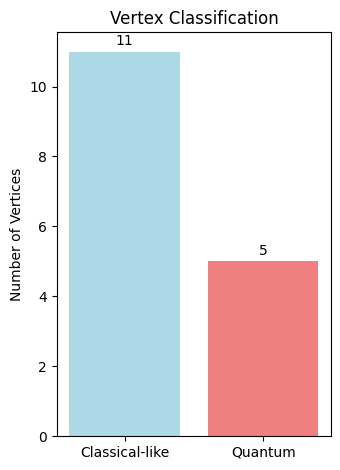


Vertex type distribution:
Types: {'0': 8, '2': 3, '1': 5}
Phases: {0: 13, Fraction(1, 1): 2, Fraction(1, 8): 1}


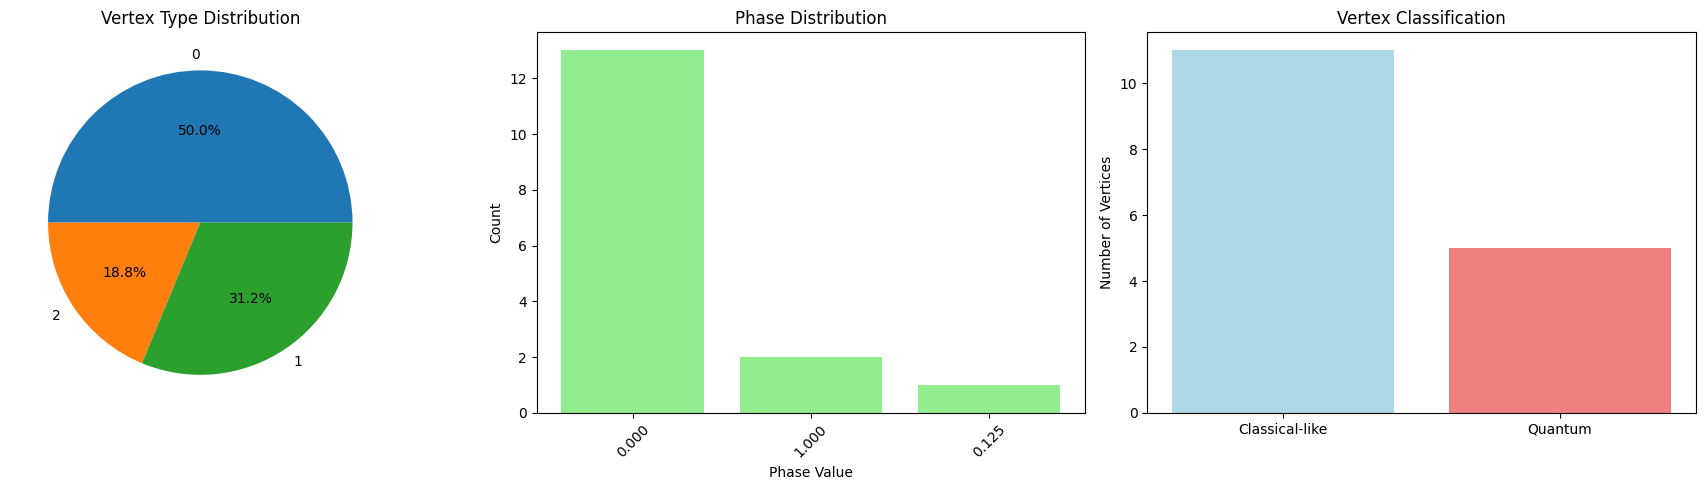

In [34]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

def analyze_classical_components(g):
    """Analyze which parts of a circuit can be implemented classically"""

    # This is a simplified version of the classicalization algorithm
    # from the paper

    classical_vertices = []
    quantum_vertices = []

    for v in g.vertices():
        vertex_type = g.type(v)
        phase = g.phase(v)

        # Fix: Use len(g.neighbors(v)) to get degree instead of g.degree(v)
        try:
            degree = len(list(g.neighbors(v)))
        except:
            # Fallback: count edges connected to this vertex
            degree = len([e for e in g.edges() if v in e])

        # Heuristic: vertices with specific phases and connections
        # might be implementable classically
        if phase in [0, Fraction(1, 1)] and degree <= 2:
            classical_vertices.append(v)
        else:
            quantum_vertices.append(v)

    print(f"Potentially classical vertices: {len(classical_vertices)}")
    print(f"Quantum vertices: {len(quantum_vertices)}")

    return classical_vertices, quantum_vertices

# Create a mixed circuit
def create_mixed_classical_quantum():
    """Create a circuit with both classical and quantum parts"""
    circ = zx.Circuit(4)

    # Classical-like operations (Pauli gates as phase rotations)
    circ.add_gate("XPhase", 0, Fraction(1, 1))  # X gate = π rotation around X
    circ.add_gate("ZPhase", 1, Fraction(1, 1))  # Z gate = π rotation around Z

    # Quantum operations
    circ.add_gate("H", 2)
    circ.add_gate("ZPhase", 2, Fraction(1, 8))  # T gate

    # Mixed operations
    circ.add_gate("CNOT", 0, 2)
    circ.add_gate("CNOT", 1, 3)

    return circ

# Create the circuit and convert to graph
mixed_circ = create_mixed_classical_quantum()
mixed_g = mixed_circ.to_graph()

# Plot only using zx.draw_matplotlib
zx.draw_matplotlib(mixed_g, figsize=(12, 6))



# Analyze components
classical_vs, quantum_vs = analyze_classical_components(mixed_g)

print(f"Circuit analysis complete:")
print(f"- Classical-like vertices: {len(classical_vs)}")
print(f"- Quantum vertices: {len(quantum_vs)}")
print("(Note: This is a simplified heuristic classification)")

# Print detailed analysis of each vertex
print("\nDetailed vertex analysis:")
for i, v in enumerate(list(mixed_g.vertices())[:10]):  # Show first 10 vertices
    vertex_type = mixed_g.type(v)
    phase = mixed_g.phase(v)
    try:
        neighbors = list(mixed_g.neighbors(v))
        degree = len(neighbors)
    except:
        degree = "unknown"

    classification = "Classical-like" if v in classical_vs else "Quantum"
    print(f"Vertex {v}: Type={vertex_type}, Phase={phase}, Degree={degree}, Class={classification}")


zx.draw_matplotlib(mixed_g, figsize=(6, 4))


plt.subplot(1, 2, 2)
# Create a simple bar chart of the analysis
categories = ['Classical-like', 'Quantum']
counts = [len(classical_vs), len(quantum_vs)]
plt.bar(categories, counts, color=['lightblue', 'lightcoral'])
plt.title('Vertex Classification')
plt.ylabel('Number of Vertices')

# Add count labels on bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Additional analysis: examine vertex types and phases
print("\nVertex type distribution:")
vertex_types = {}
vertex_phases = {}

for v in mixed_g.vertices():
    vtype = str(mixed_g.type(v))
    phase = mixed_g.phase(v)

    if vtype not in vertex_types:
        vertex_types[vtype] = 0
    vertex_types[vtype] += 1

    if phase not in vertex_phases:
        vertex_phases[phase] = 0
    vertex_phases[phase] += 1

print("Types:", vertex_types)
print("Phases:", vertex_phases)

# Create additional visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Vertex types
ax1 = axes[0]
if vertex_types:
    ax1.pie(vertex_types.values(), labels=vertex_types.keys(), autopct='%1.1f%%')
    ax1.set_title('Vertex Type Distribution')

# Phase distribution
ax2 = axes[1]
if vertex_phases:
    phases_str = [f"{float(p):.3f}" for p in vertex_phases.keys()]
    ax2.bar(phases_str, vertex_phases.values(), color='lightgreen')
    ax2.set_title('Phase Distribution')
    ax2.set_xlabel('Phase Value')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

# Classification comparison
ax3 = axes[2]
ax3.bar(['Classical-like', 'Quantum'], [len(classical_vs), len(quantum_vs)],
        color=['lightblue', 'lightcoral'])
ax3.set_title('Vertex Classification')
ax3.set_ylabel('Number of Vertices')

plt.tight_layout()
plt.show()

## 1. Construction of a Mixed Classical-Quantum Circuit
# 1.1 Circuit Initialization
Create a quantum circuit on
$[ n = 4 ]$
qubits:

$[
\text{circ} = \text{zx.Circuit}(4)
]$

# 1.2 Adding Classical-like Gates
Add gates representing classical Pauli operations expressed as phase rotations:

XPhase gate on qubit 0 with phase
$[ \pi ]$ (represented as fraction $[ \frac{1}{1} ]$):

$[
XPhase(0, \pi)
]$

ZPhase gate on qubit 1 with phase
$[ \pi ]$:

$[
ZPhase(1, \pi)
]$

These correspond to the Pauli-X and Pauli-Z gates, which can be represented as rotations of angle $\pi$ around respective axes.

# 1.3 Adding Quantum Gates
Add the Hadamard gate on qubit 2:

$[
H(2)
]$

Add the T gate (a $\frac{\pi}{4}$ phase rotation) on qubit 2, represented as:

$[
ZPhase(2, \frac{\pi}{8})
]$

The T gate introduces a non-Clifford phase, providing universal quantum computational power.

1.4 Adding Entangling Gates
Add two CNOT gates (controlled-NOT):

Control qubit 0, target qubit 2:

$[
\text{CNOT}(0, 2)
]$

Control qubit 1, target qubit 3:

$[
\text{CNOT}(1, 3)
]$

These gates create entanglement between qubits, mixing classical and quantum parts.

1.5 Return the Constructed Circuit
The function outputs the complete mixed circuit:

$[
\text{return } \text{circ}
]$

## 2. Conversion of Circuit to ZX Graph
Convert the circuit into a ZX-diagram graph representation:

$[
G = \text{circ.to_graph}()
]$

This graph captures the circuit’s operations as vertices (spiders) and edges (wires).

## 3. Visualization
Draw the ZX graph using matplotlib via PyZX’s built-in function:

$[
\text{zx.draw_matplotlib}(G, \text{figsize} = (12, 6))
]$

This produces a graphical representation of the ZX diagram, showing the topology and phases of spiders.

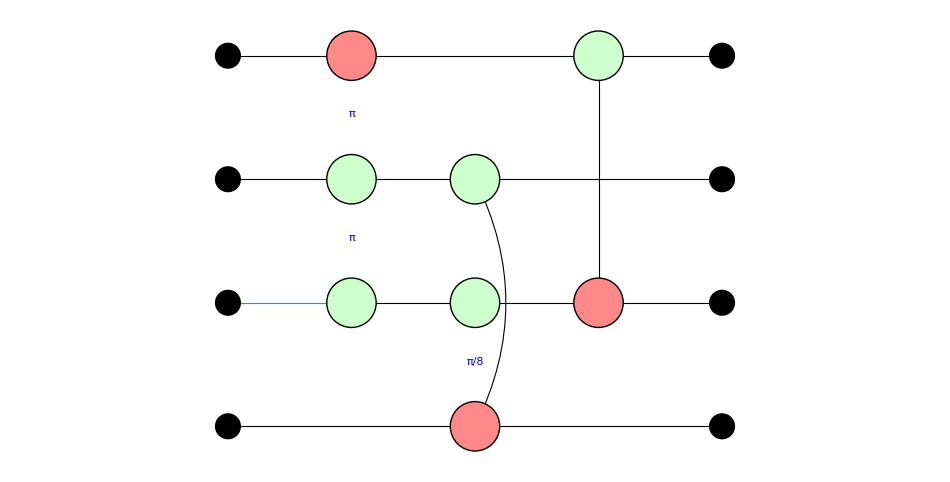

In [35]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

# Create a mixed circuit
def create_mixed_classical_quantum():
    """Create a circuit with both classical and quantum parts"""
    circ = zx.Circuit(4)

    # Classical-like operations (Pauli gates as phase rotations)
    circ.add_gate("XPhase", 0, Fraction(1, 1))  # X gate = π rotation around X
    circ.add_gate("ZPhase", 1, Fraction(1, 1))  # Z gate = π rotation around Z

    # Quantum operations
    circ.add_gate("H", 2)
    circ.add_gate("ZPhase", 2, Fraction(1, 8))  # T gate

    # Mixed operations
    circ.add_gate("CNOT", 0, 2)
    circ.add_gate("CNOT", 1, 3)

    return circ

# Create the circuit and convert to graph
mixed_circ = create_mixed_classical_quantum()
mixed_g = mixed_circ.to_graph()

# Plot only using zx.draw_matplotlib
zx.draw_matplotlib(mixed_g, figsize=(12, 6))


## 1. Benchmarking Optimization on Quantum Circuits
# 1.1 Setup and Data Structure
Initialize an empty dictionary to store optimization results:

$[
\text{results} = {}
]$

# 1.2 Pure Quantum Circuit Construction
Create a circuit with
$[n = 4]$
qubits:

$[
\text{pure_circ} = \text{zx.Circuit}(4)
]$

Apply Hadamard gates on all qubits:

$[
\forall i \in {0,1,2,3}, \quad H_i
]$

Apply a chain of CNOT gates linking qubits:

$[
\text{CNOT}_{i,i+1} \quad \text{for} \quad i = 0,1,2
]$

Apply phase rotations about Z with phase
$[ \frac{\pi}{4} ]$
on all qubits:

$[
ZPhase_i\left(\frac{\pi}{4}\right), \quad \forall i \in {0,1,2,3}
]$

Convert the circuit to a ZX graph:

$[
pure_g = pure_circ.to_graph()
]$

Measure the original number of vertices (spiders):

$[
V_{\text{original}} = pure_g.num_vertices()
]$

# 1.3 Optimization of Pure Quantum Graph
Create a copy to preserve original graph:

```
$[
pure_g_{copy} = pure_g.copy()
]$
```
Apply the full ZX-calculus reduction/simplification procedure:
```
$[
\text{zx.simplify.full_reduce}(pure_g_{copy})
]$
```
Record the optimized number of vertices:
```
$[
V_{\text{optimized}} = pure_g_{copy}.num_vertices()
]$
```
Calculate reduction:

$[
R = V_{\text{original}} - V_{\text{optimized}}
]$

Store results in dictionary:

$[
\text{results}['pure_quantum'] = {
\text{'original'}: V_{\text{original}}, ,
\text{'optimized'}: V_{\text{optimized}}, ,
\text{'reduction'}: R
}
]$

# 1.4 Hybrid Circuit Construction
Initialize a 4-qubit circuit:

$[
\text{hybrid_circ} = \text{zx.Circuit}(4)
]$

Apply Hadamard gates on all qubits:

$[
\forall i \in {0,1,2,3}, \quad H_i
]$

Apply CNOT gates linking adjacent qubits:

$[
\text{CNOT}_{i,i+1} \quad \text{for} \quad i = 0,1,2
]$

Convert to ZX graph:

$[
hybrid_g = hybrid_circ.to_graph()
]$

Get output vertices of the graph (note: method call):

$[
outputs = hybrid_g.outputs()
]$

Add “ground” vertices to simulate measurements (Z-spiders with zero phase):

For $[ i = 0, 1 ]$:

$[
g_i = \text{hybrid_g.add_vertex}(\text{ZX.VertexType.Z}, , \text{phase}=0)
]$

Connect output vertices to ground vertices:

$[
\text{hybrid_g.add_edge} \bigl( (outputs[i], g_i) \bigr)
]$

# 1.5 Optimization of Hybrid Graph
Record original number of vertices:

$[
V_{\text{original, hybrid}} = hybrid_g.num_vertices()
]$

Copy graph to preserve original:
```
$[
hybrid_g_{copy} = hybrid_g.copy()
]$
```
Simplify copied graph:
```
$[
\text{zx.simplify.full_reduce}(hybrid_g_{copy})
]$
```
Record optimized number of vertices:
```
$[
V_{\text{optimized, hybrid}} = hybrid_g_{copy}.num_vertices()
]$
```
Compute reduction:

$[
R_{\text{hybrid}} = V_{\text{original, hybrid}} - V_{\text{optimized, hybrid}}
]$

Store hybrid results:

$[
\text{results}['hybrid'] = {
\text{'original'}: V_{\text{original, hybrid}}, ,
\text{'optimized'}: V_{\text{optimized, hybrid}}, ,
\text{'reduction'}: R_{\text{hybrid}}
}
]$

1.6 Return Benchmark Results
Return the results dictionary containing both circuit analyses:

$[
\text{return results}
]$

## 2. Output and Visualization
# 2.1 Console Output
Print formatted results for each circuit type:

For each $[ c \in {\text{pure_quantum}, \text{hybrid}} ]$:

$[
\begin{cases}
\text{Original vertices: } V_{\text{original}} \
\text{Optimized vertices: } V_{\text{optimized}} \
\text{Reduction: } R = V_{\text{original}} - V_{\text{optimized}} \
\text{Reduction percentage: } \frac{R}{V_{\text{original}}} \times 100 %
\end{cases}
]$

# 2.2 Graphical Visualization
Create two bar charts side-by-side:

2.2.1 Bar Chart 1: Vertex Counts
Plot original vs optimized vertex counts for each circuit type

Circuit types on the x-axis:

$[
{ \text{Pure Quantum}, \text{Hybrid} }
]$

Y-axis shows vertex counts

Two bars per circuit type:

$[
\text{Original}, \quad \text{Optimized}
]$

2.2.2 Bar Chart 2: Reduction Percentage
Plot percentage reduction for each circuit type

Y-axis:

$[
\text{Reduction percentage } \in [0, 100]%
]$

2.3 Visualization Details
Use distinct colors for clarity:

$[
\text{Original bars} \rightarrow \text{lightcoral} \
\text{Optimized bars} \rightarrow \text{lightblue} \
\text{Reduction bars} \rightarrow \text{lightgreen}
]$

Labels and titles are added for readability.

Layout is adjusted for neat presentation.

Optimization Benchmark Results:
PURE_QUANTUM:
  Original vertices: 22
  Optimized vertices: 15
  Reduction: 7
  Reduction %: 31.8%

HYBRID:
  Original vertices: 20
  Optimized vertices: 16
  Reduction: 4
  Reduction %: 20.0%



<ipython-input-23-5480f0c74f91>:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([ct.replace('_', ' ').title() for ct in circuit_types])


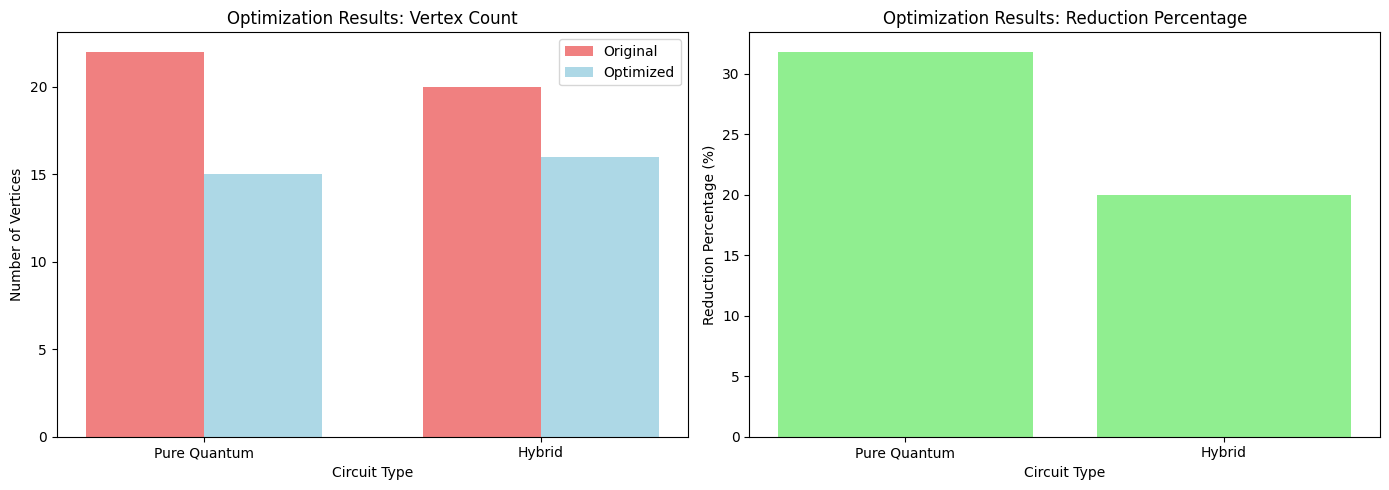

In [23]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

def benchmark_optimization():
    """Benchmark optimization on different circuit types"""

    results = {}

    # Pure quantum circuit
    pure_circ = zx.Circuit(4)
    for i in range(4):
        pure_circ.add_gate("H", i)
    for i in range(3):
        pure_circ.add_gate("CNOT", i, i+1)
    for i in range(4):
        pure_circ.add_gate("ZPhase", i, Fraction(1, 4))

    pure_g = pure_circ.to_graph()
    original_vertices = pure_g.num_vertices()

    # Optimize (work on a copy)
    pure_g_copy = pure_g.copy()
    zx.simplify.full_reduce(pure_g_copy)
    optimized_vertices = pure_g_copy.num_vertices()

    results['pure_quantum'] = {
        'original': original_vertices,
        'optimized': optimized_vertices,
        'reduction': original_vertices - optimized_vertices
    }

    # Hybrid circuit (with measurements)
    hybrid_circ = zx.Circuit(4)
    for i in range(4):
        hybrid_circ.add_gate("H", i)
    for i in range(3):
        hybrid_circ.add_gate("CNOT", i, i+1)

    hybrid_g = hybrid_circ.to_graph()

    # Fix: g.outputs is a method, need to call it
    outputs = hybrid_g.outputs()

    # Add ground generators for measurements
    for i in range(2):
        ground_v = hybrid_g.add_vertex(zx.VertexType.Z, phase=0)
        if i < len(outputs):
            hybrid_g.add_edge((outputs[i], ground_v))

    original_vertices_hybrid = hybrid_g.num_vertices()

    # Optimize (work on a copy)
    hybrid_g_copy = hybrid_g.copy()
    zx.simplify.full_reduce(hybrid_g_copy)
    optimized_vertices_hybrid = hybrid_g_copy.num_vertices()

    results['hybrid'] = {
        'original': original_vertices_hybrid,
        'optimized': optimized_vertices_hybrid,
        'reduction': original_vertices_hybrid - optimized_vertices_hybrid
    }

    return results

benchmark_results = benchmark_optimization()

print("Optimization Benchmark Results:")
print("=" * 40)
for circuit_type, data in benchmark_results.items():
    print(f"{circuit_type.upper()}:")
    print(f"  Original vertices: {data['original']}")
    print(f"  Optimized vertices: {data['optimized']}")
    print(f"  Reduction: {data['reduction']}")
    if data['original'] > 0:
        print(f"  Reduction %: {100 * data['reduction'] / data['original']:.1f}%")
    else:
        print(f"  Reduction %: 0.0%")
    print()

# Create a visualization of the benchmark results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of vertex counts
circuit_types = list(benchmark_results.keys())
original_counts = [benchmark_results[ct]['original'] for ct in circuit_types]
optimized_counts = [benchmark_results[ct]['optimized'] for ct in circuit_types]

x = range(len(circuit_types))
width = 0.35

ax1.bar([i - width/2 for i in x], original_counts, width, label='Original', color='lightcoral')
ax1.bar([i + width/2 for i in x], optimized_counts, width, label='Optimized', color='lightblue')
ax1.set_xlabel('Circuit Type')
ax1.set_ylabel('Number of Vertices')
ax1.set_title('Optimization Results: Vertex Count')
ax1.set_xticks(x)
ax1.set_xticklabels([ct.replace('_', ' ').title() for ct in circuit_types])
ax1.legend()

# Reduction percentages
reductions = [100 * benchmark_results[ct]['reduction'] / benchmark_results[ct]['original']
              if benchmark_results[ct]['original'] > 0 else 0
              for ct in circuit_types]

ax2.bar(circuit_types, reductions, color='lightgreen')
ax2.set_xlabel('Circuit Type')
ax2.set_ylabel('Reduction Percentage (%)')
ax2.set_title('Optimization Results: Reduction Percentage')
ax2.set_xticklabels([ct.replace('_', ' ').title() for ct in circuit_types])

plt.tight_layout()
plt.show()